In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib
import scipy
import copy
from simple_dispatch import bidStack
from future_grid import FutureDemand_v2
from future_grid import FutureGrid_v2
import cvxpy
import os

In [2]:
def calculate_signals(dpdf, year, signals_save):
    
    aef = (dpdf['co2_tot'] / dpdf['total_incl_noncombustion']).values.reshape((-1, 24)).mean(axis=0)
    signals_save['AEF_'+str(year)] = aef

    inds = dpdf.loc[pd.to_datetime(dpdf['datetime']).dt.weekday.isin([0, 1, 2, 3, 4])].index
    aef = (dpdf.loc[inds, 'co2_tot'] / dpdf.loc[inds, 'total_incl_noncombustion']).values.reshape((-1, 24)).mean(axis=0)
    signals_save['AEF_weekday_'+str(year)] = aef

    inds = dpdf.loc[pd.to_datetime(dpdf['datetime']).dt.weekday.isin([5, 6])].index
    aef = (dpdf.loc[inds, 'co2_tot'] / dpdf.loc[inds, 'total_incl_noncombustion']).values.reshape((-1, 24)).mean(axis=0)
    signals_save['AEF_weekend_'+str(year)] = aef

    mef = dpdf['co2_marg'].values.reshape((-1, 24)).mean(axis=0)
    signals_save['MEF_'+str(year)] = mef

    inds = dpdf.loc[pd.to_datetime(dpdf['datetime']).dt.weekday.isin([0, 1, 2, 3, 4])].index
    mef = dpdf.loc[inds, 'co2_marg'].values.reshape((-1, 24)).mean(axis=0)
    signals_save['MEF_weekday_'+str(year)] = mef

    inds = dpdf.loc[pd.to_datetime(dpdf['datetime']).dt.weekday.isin([5, 6])].index
    mef = dpdf.loc[inds, 'co2_marg'].values.reshape((-1, 24)).mean(axis=0)
    signals_save['MEF_weekend_'+str(year)] = mef

    return signals_save

# No EV signals

### 2022 Base, Analysis from 2023

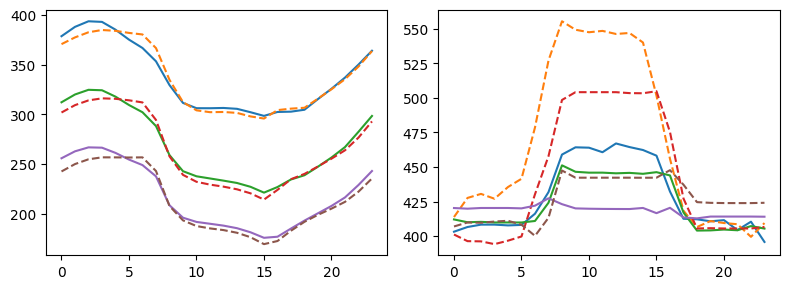

In [5]:
folder = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_2022BASE_20240212'
load_date = '20240212'
save_date = '20240212'
signals_save = {}
for year in np.arange(2023, 2038):
    dpdf = pd.read_csv(folder+'/noblock_year'+str(year)+'_storagebefore_withstorage_dpdf_'+load_date+'.csv')
    signals_save = calculate_signals(dpdf, year, signals_save)
    
fig, axes = plt.subplots(1, 2, figsize=(8,3))
for year in [2023, 2028, 2033]:
    axes[0].plot(signals_save['AEF_weekday_'+str(year)], label=year)
    axes[1].plot(signals_save['MEF_weekday_'+str(year)], label=year)
    axes[0].plot(signals_save['AEF_weekend_'+str(year)], '--', label=year)
    axes[1].plot(signals_save['MEF_weekend_'+str(year)], '--', label=year)
plt.tight_layout()
plt.show()

In [6]:
pd.DataFrame(signals_save).to_csv('../Data/signals_df_aef_mef_storagebefore_noevbase_2022BASE_'+save_date+'.csv')

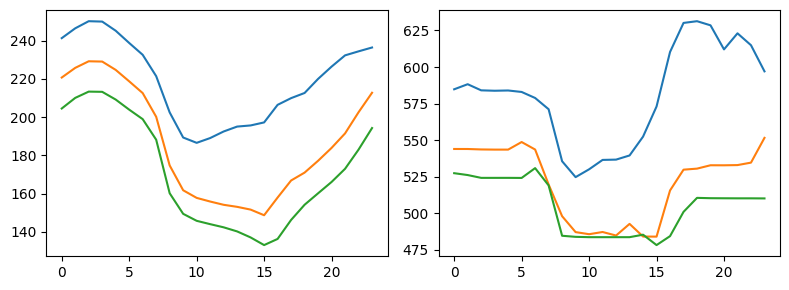

In [7]:
folder = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_CO2_2022BASE_20240212/'
signals_save = {}
for year in np.arange(2023, 2038):
    dpdf = pd.read_csv(folder+'/noblock_year'+str(year)+'_co2price_01dolperkg_storagebefore_withstorage_dpdf_'+load_date+'.csv')
    signals_save = calculate_signals(dpdf, year, signals_save)
    
fig, axes = plt.subplots(1, 2, figsize=(8,3))
for year in [2023, 2028, 2033]:#, 2035]:
    axes[0].plot(signals_save['AEF_weekday_'+str(year)], label=year)
    axes[1].plot(signals_save['MEF_weekday_'+str(year)], label=year)
plt.tight_layout()
plt.show()

pd.DataFrame(signals_save).to_csv('../Data/signals_df_aef_mef_storagebefore_noevbase_co2price_01dolperkg_2022BASE_'+save_date+'.csv')

# MRMEF

In [23]:
folder1 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_2022BASE_20240212/'
folder2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_2022BASE_20240214/'
load_date1 = '20240212'
save_date1 = '20240212'
load_date2 = '20240214'
save_date2 = '20240214'

year_set_all = np.arange(2023, 2038)
year_set_small = np.arange(2023, 2038)

cols = ['deltaMW'+str(deltaMW)+'_'+name+'_'+str(year)+'_'+weekday for deltaMW in [10000, 20000] for name in ['Delta_Emissions', 'Delta_Demand'] for year in year_set_all for weekday in ['weekday', 'weekend']]
mrmef_df = pd.DataFrame(np.zeros((24, len(cols))), columns=cols)

for deltaMW in [10000]:
    for weekday in ['weekday', 'weekend']:
        for year in year_set_all:
            refpt = pd.read_csv(folder1+'noblock_year'+str(year)+'_storagebefore_withstorage_dpdf_'+load_date1+'.csv')
            for hour in np.arange(0, 24):
                dpdf = pd.read_csv(folder1+'MRMEF_deltaMW'+str(deltaMW)+'_hour'+str(hour)+'_year'+str(year)+'_'+weekday+'_storagebefore_withstorage_dpdf_'+load_date1+'.csv')
                mrmef_df.loc[hour, 'deltaMW'+str(deltaMW)+'_Delta_Emissions_'+str(year)+'_'+weekday] = dpdf['co2_tot'].sum() - refpt.co2_tot.sum()
                mrmef_df.loc[hour, 'deltaMW'+str(deltaMW)+'_Delta_Demand_'+str(year)+'_'+weekday] = dpdf['total_incl_noncombustion'].sum() - refpt.total_incl_noncombustion.sum()
for deltaMW in [20000]:
    for weekday in ['weekday', 'weekend']:
        for year in year_set_all:
            refpt = pd.read_csv(folder1+'noblock_year'+str(year)+'_storagebefore_withstorage_dpdf_'+load_date1+'.csv')
            for hour in np.arange(0, 24):
                dpdf = pd.read_csv(folder2+'MRMEF_deltaMW'+str(deltaMW)+'_hour'+str(hour)+'_year'+str(year)+'_'+weekday+'_storagebefore_withstorage_dpdf_'+load_date2+'.csv')
                mrmef_df.loc[hour, 'deltaMW'+str(deltaMW)+'_Delta_Emissions_'+str(year)+'_'+weekday] = dpdf['co2_tot'].sum() - refpt.co2_tot.sum()
                mrmef_df.loc[hour, 'deltaMW'+str(deltaMW)+'_Delta_Demand_'+str(year)+'_'+weekday] = dpdf['total_incl_noncombustion'].sum() - refpt.total_incl_noncombustion.sum()


In [24]:
year_set_all = np.arange(2023, 2038)
signals_save_mrmef = {}
max_year = 2038
years_ahead = 5
for deltaMW in [10000, 20000]:
    for year_here in year_set_all:
        for weekday in ['weekday', 'weekend']:
            year_set = np.arange(year_here, min(year_here+years_ahead, max_year))
            mrmef = mrmef_df.loc[:, ['deltaMW'+str(deltaMW)+'_Delta_Emissions_'+str(year)+'_'+weekday for year in year_set]].sum(axis=1) / mrmef_df.loc[:, ['deltaMW'+str(deltaMW)+'_Delta_Demand_'+str(year)+'_'+weekday for year in year_set]].sum(axis=1)
            signals_save_mrmef['MRMEF_delta'+str(deltaMW)+'_startyear'+str(year_here)+'_'+str(years_ahead)+'yearsahead'+'_'+weekday] = mrmef
signals_save_mrmef_df = pd.DataFrame(signals_save_mrmef)

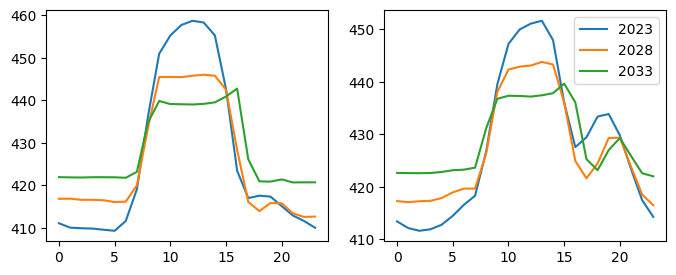

In [26]:
plt.figure(figsize=(8,3))
plt.subplot(121)
for year in [2023, 2028, 2033]:
    plt.plot(signals_save_mrmef_df['MRMEF_delta10000_startyear'+str(year)+'_5yearsahead_weekday'], label=year)
plt.subplot(122)
for year in [2023, 2028, 2033]:
    plt.plot(signals_save_mrmef_df['MRMEF_delta20000_startyear'+str(year)+'_5yearsahead_weekday'], label=year)
plt.legend()
plt.show()

In [27]:
signals_save_mrmef_df.to_csv('../Data/signals_df_mrmef_storagebefore_noevbase_2022BASE_'+save_date+'.csv')

In [28]:
save_date

'20240212'

# MRMEF with CO2

In [30]:
folder = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_CO2_2022BASE_20240212/'
load_date = '20240212'
save_date = '20240212'

year_set_all = np.arange(2023, 2038)
year_set_small = np.arange(2023, 2038)

cols = ['deltaMW'+str(deltaMW)+'_'+name+'_'+str(year)+'_'+weekday for deltaMW in [10000, 20000] for name in ['Delta_Emissions', 'Delta_Demand'] for year in year_set for weekday in ['weekday', 'weekend']]
mrmef_df_co2 = pd.DataFrame(np.zeros((24, len(cols))), columns=cols)

for deltaMW in [10000]:
    for weekday in ['weekday', 'weekend']:
        for year in year_set_all:
            refpt = pd.read_csv(folder+'noblock_year'+str(year)+'_co2price_01dolperkg_storagebefore_withstorage_dpdf_'+load_date+'.csv')
            for hour in np.arange(0, 24):
                dpdf = pd.read_csv(folder+'MRMEF_deltaMW'+str(deltaMW)+'_hour'+str(hour)+'_year'+str(year)+'_'+weekday+'_co2price_01dolperkg_storagebefore_withstorage_dpdf_'+load_date+'.csv')
                mrmef_df_co2.loc[hour, 'deltaMW'+str(deltaMW)+'_Delta_Emissions_'+str(year)+'_'+weekday] = dpdf['co2_tot'].sum() - refpt.co2_tot.sum()
                mrmef_df_co2.loc[hour, 'deltaMW'+str(deltaMW)+'_Delta_Demand_'+str(year)+'_'+weekday] = dpdf['total_incl_noncombustion'].sum() - refpt.total_incl_noncombustion.sum()


In [32]:
folder2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_CO2_2022BASE_20240214/'
load_date2 = '20240214'

for deltaMW in [20000]:
    for weekday in ['weekday', 'weekend']:
        for year in year_set_all:
            refpt = pd.read_csv(folder+'noblock_year'+str(year)+'_co2price_01dolperkg_storagebefore_withstorage_dpdf_'+load_date+'.csv')
            for hour in np.arange(0, 24):
                dpdf = pd.read_csv(folder2+'MRMEF_deltaMW'+str(deltaMW)+'_hour'+str(hour)+'_year'+str(year)+'_'+weekday+'_co2price_01dolperkg_storagebefore_withstorage_dpdf_'+load_date2+'.csv')
                mrmef_df_co2.loc[hour, 'deltaMW'+str(deltaMW)+'_Delta_Emissions_'+str(year)+'_'+weekday] = dpdf['co2_tot'].sum() - refpt.co2_tot.sum()
                mrmef_df_co2.loc[hour, 'deltaMW'+str(deltaMW)+'_Delta_Demand_'+str(year)+'_'+weekday] = dpdf['total_incl_noncombustion'].sum() - refpt.total_incl_noncombustion.sum()


/var/folders/x0/47mhggk13ms4ct1vkkn6b88r0000gs/T/ipykernel_16630/4076353363.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mrmef_df_co2.loc[hour, 'deltaMW'+str(deltaMW)+'_Delta_Demand_'+str(year)+'_'+weekday] = dpdf['total_incl_noncombustion'].sum() - refpt.total_incl_noncombustion.sum()
/var/folders/x0/47mhggk13ms4ct1vkkn6b88r0000gs/T/ipykernel_16630/4076353363.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mrmef_df_co2.loc[hour, 'deltaMW'+str(deltaMW)+'_Delta_Emissions_'+str(year)+'_'+weekday] = dpdf['co2_tot'].sum

In [33]:
signals_save_mrmef_co2 = {}
max_year = 2038
years_ahead = 5
for deltaMW in [10000, 20000]:
    for year_here in year_set_all:
        for weekday in ['weekday', 'weekend']:
            year_set = np.arange(year_here, min(year_here+years_ahead, max_year))
            mrmef = mrmef_df_co2.loc[:, ['deltaMW'+str(deltaMW)+'_Delta_Emissions_'+str(year)+'_'+weekday for year in year_set]].sum(axis=1) / mrmef_df_co2.loc[:, ['deltaMW'+str(deltaMW)+'_Delta_Demand_'+str(year)+'_'+weekday for year in year_set]].sum(axis=1)
            signals_save_mrmef_co2['MRMEF_delta'+str(deltaMW)+'_startyear'+str(year_here)+'_'+str(years_ahead)+'yearsahead'+'_'+weekday] = mrmef

signals_save_mrmef_df_co2 = pd.DataFrame(signals_save_mrmef_co2)

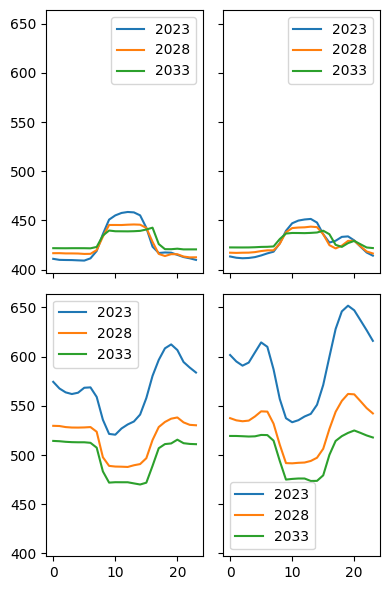

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(4, 6), sharex=True, sharey=True)
for ax, deltaMW in {axes[0, 0]:10000, axes[0, 1]:20000}.items():
    for year in [2023, 2028, 2033]:
        ax.plot(signals_save_mrmef_df['MRMEF_delta'+str(deltaMW)+'_startyear'+str(year)+'_5yearsahead_weekday'], label=str(year))
    ax.legend()
for ax, deltaMW in {axes[1, 0]:10000, axes[1, 1]:20000}.items():
    for year in [2023, 2028, 2033]:
        ax.plot(signals_save_mrmef_df_co2['MRMEF_delta'+str(deltaMW)+'_startyear'+str(year)+'_5yearsahead_weekday'], label=str(year))
    ax.legend()
plt.tight_layout()
plt.show()

In [36]:
save_date

'20240212'

In [37]:
signals_save_mrmef_df_co2.to_csv('../Data/signals_df_mrmef_storagebefore_noevbase_co2price_01dolperkg_2022BASE_'+save_date+'.csv')